In [1]:
# !git clone https://github.com/deepmind/dsprites-dataset.git

In [2]:
import tensorflow as tf 
tf.enable_eager_execution()

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

In [9]:
## Code from Deepmind's Github
load_data = np.load("dsprites-dataset/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz", encoding='bytes')
imgs = load_data['imgs']
latents_values = load_data['latents_values']
latents_classes = load_data['latents_classes']
metadata = load_data['metadata'][()]

experiment_name = "Beta-VAESprite"

print('Metadata: \n', metadata)

Metadata: 
 {b'date': b'April 2017', b'description': b'Disentanglement test Sprites dataset.Procedurally generated 2D shapes, from 6 disentangled latent factors.This dataset uses 6 latents, controlling the color, shape, scale, rotation and position of a sprite. All possible variations of the latents are present. Ordering along dimension 1 is fixed and can be mapped back to the exact latent values that generated that image.We made sure that the pixel outputs are different. No noise added.', b'version': 1, b'latents_names': (b'color', b'shape', b'scale', b'orientation', b'posX', b'posY'), b'latents_possible_values': {b'orientation': array([0.        , 0.16110732, 0.32221463, 0.48332195, 0.64442926,
       0.80553658, 0.96664389, 1.12775121, 1.28885852, 1.44996584,
       1.61107316, 1.77218047, 1.93328779, 2.0943951 , 2.25550242,
       2.41660973, 2.57771705, 2.73882436, 2.89993168, 3.061039  ,
       3.22214631, 3.38325363, 3.54436094, 3.70546826, 3.86657557,
       4.02768289, 4.18879

In [10]:
latents_sizes = metadata[b'latents_sizes']
latents_bases = np.concatenate((latents_sizes[::-1].cumprod()[::-1][1:],
                                np.array([1,])))

def latent_to_index(latents):
    return np.dot(latents, latents_bases).astype(int)

def sample_latent(size=1):
    samples = np.zeros((size, latents_sizes.size))
    for lat_i, lat_size in enumerate(latents_sizes):
        samples[:, lat_i] = np.random.randint(lat_size, size=size)

    return samples

def show_images_grid(imgs_, num_images=25):
    ncols = int(np.ceil(num_images**0.5))
    nrows = int(np.ceil(num_images / ncols))
    _, axes = plt.subplots(ncols, nrows, figsize=(nrows * 3, ncols * 3))
    axes = axes.flatten()

    for ax_i, ax in enumerate(axes):
        if ax_i < num_images:
            ax.imshow(imgs_[ax_i], cmap='Greys_r',  interpolation='nearest')
            ax.set_xticks([])
            ax.set_yticks([])
        else:
            ax.axis('off')

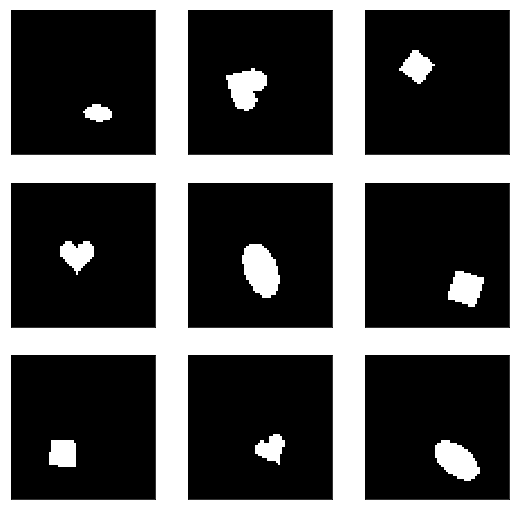

In [11]:
latents_sampled = sample_latent(size=60000)

# latents_sampled[:, 1] = 1
indices_sampled = latent_to_index(latents_sampled)
imgs_sampled = imgs[indices_sampled]

show_images_grid(imgs_sampled, 9)

In [12]:
imgs_sampled = imgs_sampled.reshape(imgs_sampled.shape[0], 64, 64, 1).astype('float32')

In [13]:
TRAIN_BUF = 60000
BATCH_SIZE = 100

TEST_BUF = 10000

In [14]:
train_dataset = tf.data.Dataset.from_tensor_slices(imgs_sampled).shuffle(TRAIN_BUF).batch(BATCH_SIZE)

In [15]:
class BetaVAESprite(tf.keras.Model):
    """Same Architecture"""
    def __init__(self, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim
        
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(64, 64, 1)),
            tf.keras.layers.Conv2D(filters=32, kernel_size=4, strides=(2, 2), activation=tf.nn.elu),
            tf.keras.layers.Conv2D(filters=32, kernel_size=4, strides=(2, 2), activation=tf.nn.elu),
            tf.keras.layers.Conv2D(filters=64, kernel_size=4, strides=(2, 2), activation=tf.nn.elu),
            tf.keras.layers.Conv2D(filters=64, kernel_size=4, strides=(2, 2), activation=tf.nn.elu),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ])
        
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=2*2*64, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(2, 2, 64)),
            tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=4, strides=(2, 2), padding="SAME", activation=tf.nn.elu),
            tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=4, strides=(2, 2), padding="SAME", activation=tf.nn.elu),
            tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=4, strides=(4, 4), padding="SAME", activation=tf.nn.elu),
            tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=2, strides=(2, 2), padding="SAME", activation=tf.nn.elu),
            tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=1, strides=(1, 1), padding="SAME"),
        ])
        
    def sample(self):
        latent = tf.random_normal(shape=(1, self.latent_dim))
        return latent, tf.nn.sigmoid(self.decoder(latent))
    
    def call(self, img, is_sigmoid=False):
        """Reuse the code from the Google Example"""
        mean, log_var = tf.split(self.encoder(img), num_or_size_splits=2, axis=1)
        
        normal = tf.random_normal(shape=mean.shape)
        latent = normal * tf.exp(log_var * .5) + mean
        
        out = self.decoder(latent)
        if is_sigmoid:
            out = tf.nn.sigmoid(out)
        return latent, out, mean, log_var

In [16]:
vae = BetaVAESprite(10)
global_step = tf.train.get_or_create_global_step()
summary_writer = tf.contrib.summary.create_file_writer(f"tmp/{experiment_name}")

In [17]:
optimizer = tf.train.AdamOptimizer(5e-5)
saver = tf.train.Checkpoint(optimizer=optimizer,
                            model=vae,
                            optimizer_step=tf.train.get_or_create_global_step())

save_path = f"save/{experiment_name}"
if not os.path.exists(save_path):
    os.mkdir(save_path)

In [19]:
for e in range(4):
    print(f"At epoch {e}")
    for i, img in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            tape.watch(vae.variables)

            latent, out, mean, log_var = vae(img)
            
            # Reconstruction loss ? 
            cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=out, labels=img)
            logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
            
            # KL Loss -- From https://wiseodd.github.io/techblog/2017/01/24/vae-pytorch/
            kl_loss = 0.5 * tf.reduce_sum(tf.exp(log_var) + mean**2 - 1. - log_var, axis=[1])
            
            # only change the beta-value lol
            loss = -tf.reduce_mean(logpx_z - 4 * kl_loss)
            if i % 100 == 0:
                print(loss)
                with summary_writer.as_default(), tf.contrib.summary.always_record_summaries():
                    tf.contrib.summary.scalar('Loss', loss)
                    tf.contrib.summary.image('Before', img)
                    tf.contrib.summary.image('Sample', out)
                    
        global_step.assign_add(1)
        grad = tape.gradient(loss, vae.variables)
        optimizer.apply_gradients(zip(grad, vae.variables))
    print(f"---------")
    saver.save(f"save/{experiment_name}/{experiment_name}.ckpt")

At epoch 0
tf.Tensor(186.78613, shape=(), dtype=float32)
tf.Tensor(189.5258, shape=(), dtype=float32)
tf.Tensor(191.86438, shape=(), dtype=float32)
tf.Tensor(191.87828, shape=(), dtype=float32)
tf.Tensor(179.6054, shape=(), dtype=float32)
tf.Tensor(179.72687, shape=(), dtype=float32)
---------
At epoch 1
tf.Tensor(181.75967, shape=(), dtype=float32)
tf.Tensor(182.14566, shape=(), dtype=float32)
tf.Tensor(180.10051, shape=(), dtype=float32)
tf.Tensor(180.12369, shape=(), dtype=float32)
tf.Tensor(181.22098, shape=(), dtype=float32)
tf.Tensor(176.02496, shape=(), dtype=float32)
---------
At epoch 2
tf.Tensor(178.69714, shape=(), dtype=float32)
tf.Tensor(179.26117, shape=(), dtype=float32)
tf.Tensor(171.90875, shape=(), dtype=float32)
tf.Tensor(173.99649, shape=(), dtype=float32)
tf.Tensor(175.24399, shape=(), dtype=float32)
tf.Tensor(175.56096, shape=(), dtype=float32)
---------
At epoch 3
tf.Tensor(176.49496, shape=(), dtype=float32)
tf.Tensor(179.28448, shape=(), dtype=float32)
tf.Tenso

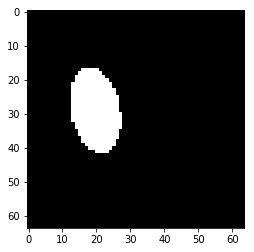

In [20]:
latents_sampled = sample_latent(size=1)

latents_sampled[:, 2] = 5
indices_sampled = latent_to_index(latents_sampled)
imgs_sampled = imgs[indices_sampled]

test_img = imgs_sampled[0]
plt.imshow(test_img, cmap='Greys_r',  interpolation='nearest')

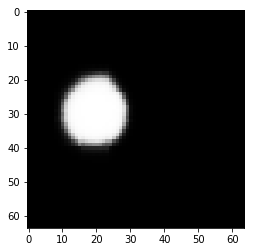

In [21]:
img_tensor = tf.convert_to_tensor(test_img, dtype=tf.float32)
img_tensor = tf.expand_dims(img_tensor, axis=0)
img_tensor = tf.expand_dims(img_tensor, axis=-1)

latent, out, _, _ = vae(img_tensor)
out = tf.squeeze(tf.nn.sigmoid(out))

plt.imshow(out.numpy(), cmap='Greys_r',  interpolation='nearest')

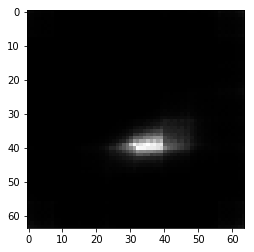

In [30]:
sampled_latent, img = vae.sample()
img = tf.squeeze(img)

plt.imshow(img.numpy(), cmap='Greys_r',  interpolation='nearest')

In [31]:
diff = latent - sampled_latent
number_steps = 10
diff = diff/number_steps 
diff

<tf.Tensor: id=2126334, shape=(1, 10), dtype=float32, numpy=
array([[ 0.1078223 ,  0.12348883, -0.20408444, -0.10269272,  0.06402662,
        -0.15336803, -0.21589708, -0.13799842,  0.09691712,  0.03250189]],
      dtype=float32)>

In [32]:
middle = sampled_latent
frames = []
for i in range(number_steps):
    out = tf.nn.sigmoid(vae.decoder(middle))
    out = tf.squeeze(out)
    frames.append(out.numpy())
    plt.show()
    middle += diff

frames = np.stack(frames)
frames.shape

(10, 64, 64)

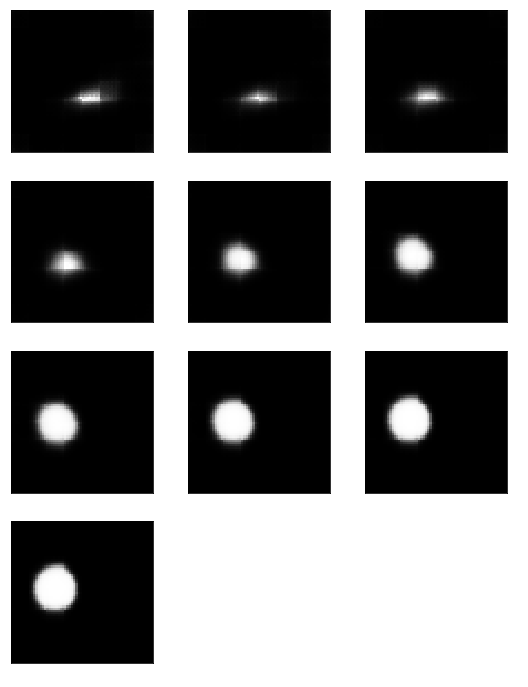

In [33]:
show_images_grid(frames, num_images=10)

<tf.Tensor: id=2123952, shape=(1, 10), dtype=float32, numpy=
array([[ 0.91322297,  0.09005135, -1.8771529 , -0.63906765, -0.20969993,
        -0.8592295 , -1.8279468 ,  0.1331418 , -0.00553007,  0.7829398 ]],
      dtype=float32)>

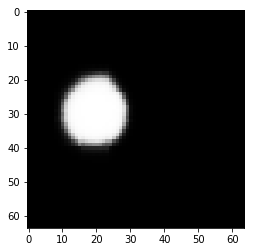

In [34]:
out = vae.decoder(latent)
out = tf.squeeze(tf.nn.sigmoid(out))

plt.imshow(out.numpy(), cmap='Greys_r',  interpolation='nearest')
latent

In [35]:
def traverse_latent(latent, axis, traverse_length=9, total_step=9):
    step_size = traverse_length * 2 / total_step
    item = latent[:, axis]
    
    item_evolution = []
    item = item - traverse_length
    import copy
    for i in range(total_step):
        new_latent = copy.deepcopy(latent)
        new_latent[:, axis] = item
        item_evolution.append(new_latent)
        item += step_size
        
    traversed_latent = np.squeeze(np.stack(item_evolution))
    return traversed_latent

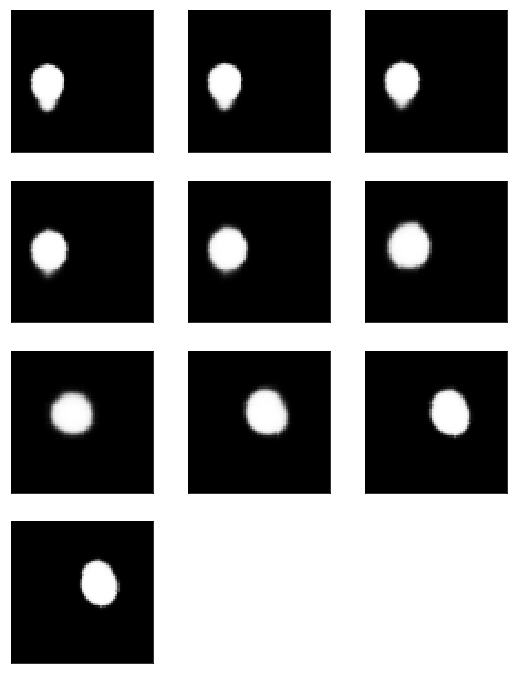

In [38]:
all_latent = traverse_latent(latent.numpy(), 2, total_step=10)
out = vae.decoder(tf.convert_to_tensor(all_latent))
out = tf.squeeze(tf.nn.sigmoid(out))

show_images_grid(out.numpy(), 10)